# Additional Examples

## Light-Pulse atom interferometry with single Bragg scattering

In this example we show the time propagation of a gaussian wave packet that will be brought in a superposition of momentum states via a position and time dependent periodic potential.
This periodic potential is usually generated by laser sources and the wave packets can be, for example, a Bose-Einstein condensate.

We start with a gaussian wave packet offset by -25 position units and zero moneutm $k=0$.

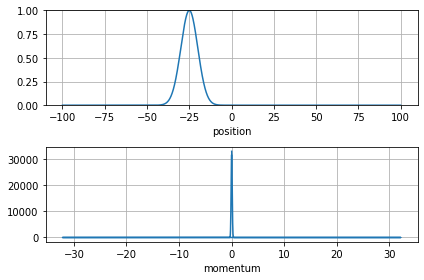

In [1]:
import pytalises as pt
from matplotlib import pyplot as plt
import numpy as np

psi = pt.Wavefunction("exp(-((x-x0)/(2*sigmax))**2)", number_of_grid_points=(2048,),
    spatial_ext=(-100,100), variables={'x0': -25, 'sigmax': 5})

def init_plot():
    fig = plt.figure()
    axs = fig.subplots(2,1)
    line1, = axs[0].plot(psi.r, np.abs(psi.amp)**2)
    axs[0].grid()
    axs[0].set_ylim(0,1)
    axs[0].set_xlabel("position")
    psi.fft();
    line2, = axs[1].plot(psi.k, np.abs(psi.amp)**2)
    axs[1].grid()
    axs[1].set_xlabel("momentum")
    psi.ifft();
    fig.tight_layout()
    return fig, axs, line1, line2

fig, axs, line1, line2 = init_plot()

You see the wave function in position and momentum representation. In position space it is ineed offset and in momentum space centered at 0.

We will now perform the first Bragg pulse.
The effective potential is


$$
V(x,t)/\hbar = 2\Omega \cos^2 (k(x-k t)),
$$


with Rabi frequency $\Omega$ and wave vector $k$. This potential drives transitions between the momentum states
$|p\rangle \leftrightarrow |p+2k\rangle$.
In this case we set $k=5$ and $\Omega=2\pi$. A beamsplitter $\pi/2$ pulse is achieved after $t=\frac{\pi/2}{\Omega}$

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_bragg_pulse(i):
    psi.propagate("2*Omega*cos(k*(x-k*t))**2", num_time_steps=1,
        delta_t=t_end/num_time_steps, variables={"Omega": 2*np.pi*f_R, "k": 5}, diag=True)
    line1.set_ydata(np.abs(psi.amp)**2)
    psi.fft()
    line2.set_ydata(np.abs(psi.amp)**2)
    psi.ifft()
    return (line1, line2)

fig, axs, line1, line2 = init_plot()

f_R = 1 # Rabi frequency in Hertz
t_end = 1/(4*f_R) # 50:50 beamsplitter
num_time_steps = 100

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

As expected the pulse results in an equal superposition of momenutm states $|p\rangle$ and $|p+2k\rangle$.

In position space we already start to see interference from now two wave packets moving apart.

The wave function is now freely propagated for 5 time units such that both wave packets are seperated by $k t=50$ position units.

In [3]:
def animate_freeprop(i):
    psi.freely_propagate(num_time_steps=1, delta_t=t_end/num_time_steps)
    line1.set_ydata(np.abs(psi.amp)**2)
    psi.fft()
    line2.set_ydata(np.abs(psi.amp)**2)
    psi.ifft()
    return (line1, line2)

fig, axs, line1, line2 = init_plot()

t_end = 5

anim = animation.FuncAnimation(fig, animate_freeprop, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now we will apply a mirror $\pi$ pulse that will invert the momentum states in order to recombine both wave packets.

In [4]:
fig, axs, line1, line2 = init_plot()

f_R = 1 # Rabi frequency in Hertz
t_end = 1/(2*f_R) # mirror pulse

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now the right wave packet will be in momentum state $|p\rangle$ and the left in $|p+2k\rangle$. They propagate freely for the same time they were seperating after the first pulse.

In [5]:
fig, axs, line1, line2 = init_plot()

t_end = 5

anim = animation.FuncAnimation(fig, animate_freeprop, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now that they are spatially overlapping we can recombine them with a final beamsplitter pulse.

In [6]:
fig, axs, line1, line2 = init_plot()

f_R = 1 # Rabi frequency in Hertz
t_end = 1/(4*f_R) # 50:50 beamspliter pulse

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())